In [1]:
import os
from typing import Literal, Annotated
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.prebuilt import create_react_agent
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
load_dotenv()

True

In [3]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
llm = ChatGroq(model_name="Llama3-8b-8192")

In [6]:
search_tool = TavilySearchResults()
search_tool.invoke("What is GDP of India?")

[{'title': 'Economy of India - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Economy_of_India',
  'content': '*   ![Image 8: Increase](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Increase2.svg/20px-Increase2.svg.png) $17.65 trillion ([PPP](https://en.wikipedia.org/wiki/Purchasing_power_parity "Purchasing power parity"); 2025 est.)[[6]](https://en.wikipedia.org/wiki/Economy_of_India#cite_note-ID-6)\nGDP rank*   [4th (nominal; 2025)](https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal) "List of countries by GDP (nominal)") [...] [GDP](https://en.wikipedia.org/wiki/Gross_domestic_product "Gross domestic product")*   ![Image 7: Increase](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Increase2.svg/20px-Increase2.svg.png) $4.19 trillion ([nominal](https://en.wikipedia.org/wiki/GDP_(nominal) "GDP (nominal)"); 2025 est.)[[6]](https://en.wikipedia.org/wiki/Economy_of_India#cite_note-ID-6) [...] GDP per capita*   ![Image 12: Increase](https://upload.wi

In [7]:
result = search_tool.invoke("What is GDP of India?")

In [8]:
result[0]['content']

'*   ![Image 8: Increase](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Increase2.svg/20px-Increase2.svg.png) $17.65 trillion ([PPP](https://en.wikipedia.org/wiki/Purchasing_power_parity "Purchasing power parity"); 2025 est.)[[6]](https://en.wikipedia.org/wiki/Economy_of_India#cite_note-ID-6)\nGDP rank*   [4th (nominal; 2025)](https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal) "List of countries by GDP (nominal)") [...] [GDP](https://en.wikipedia.org/wiki/Gross_domestic_product "Gross domestic product")*   ![Image 7: Increase](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Increase2.svg/20px-Increase2.svg.png) $4.19 trillion ([nominal](https://en.wikipedia.org/wiki/GDP_(nominal) "GDP (nominal)"); 2025 est.)[[6]](https://en.wikipedia.org/wiki/Economy_of_India#cite_note-ID-6) [...] GDP per capita*   ![Image 12: Increase](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Increase2.svg/20px-Increase2.svg.png) $2,878 (nominal; 2025 est.)[[8]](htt

In [9]:
# Python code
code = """
x = 5
y = x * 2
print(y)
"""

In [10]:
repl = PythonREPL()
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [11]:
@tool
def python_repl_tool(code: Annotated[str, "The python code to generate your chart."]):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with 'print(...)'. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\'\'\'python\n{code}\n\'\'\'\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [12]:
def make_system_prompt(instruction:str)->str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable, "
        " prefix your response with FINAL ANSWER so the team know to stop."
        f"\n{instruction}"
    )

In [13]:
def get_next_node(last_massage: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_massage.content:
        return END
    return goto

In [14]:
research_agent = create_react_agent(
    llm,
    tools = [search_tool],
    prompt = make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    )
)

In [15]:
chart_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    )
)

In [16]:
def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    
    result = research_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "chart_generator")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    
    return Command(update={"messages": result["messages"]}, goto=goto)

In [17]:
def chart_node(state:MessagesState)->Command[Literal["researcher", END]]:
    
    result = chart_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "reseacher")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    
    return Command(update={"messages": result["messages"]}, goto=goto)

In [18]:
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_edge(START, "researcher")
app = workflow.compile()

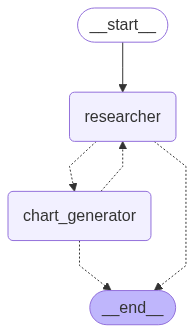

In [19]:
display(Image(app.get_graph().draw_mermaid_png()))

In [20]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})

{'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='d741a29e-2207-45ed-81b4-e5f2f615431c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '101h9akzf', 'function': {'arguments': '{"query":"UK GDP over the past 3 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 1045, 'total_tokens': 1138, 'completion_time': 0.0775, 'prompt_time': 0.130625932, 'queue_time': 0.249544257, 'total_time': 0.208125932}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--73b68c11-80c1-45f7-a3bb-5652243a7568-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP over the past 3 years'}, 'id': '101h9akzf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 